##### Copyright 2024 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Workshop: How to Fine-tuning Gemma - Transformers Edition

To illustrate fine-tuning the model for a specific task, You'll learn how to condition a Gemma model to answer in a specific language. Let's consider the example of generating a random Portuguese title based on a user's instruction such as "Write a title". To make this possible, you will curate a manageable dataset that can be manually processed. This approach is feasible because Gemma 2 has prior knowledge of general Portuguese language patterns, enabling it to adapt to this specific task effectively.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/gemma-cookbook/blob/main/Workshops/Workshop_How_to_Fine_tuning_Gemma_Transformers_Edition.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

## What is Fine-tuning

In the first place, you have to understand what is fine-tuning. It's a specialized form of [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning). It involves taking a pre-trained language model - one that has already been exposed to a vast corpus of text data and learned the general patterns and structures of language - and further training it on a smaller, more specific dataset. This additional training allows the model to adapt and refine its knowledge, making it better suited for a particular task or domain.

Imagine you are a skilled gamer who excels at various genres, from action-adventures to strategy games. Fine-tuning is akin to taking you and having you focus intensely on mastering a specific game, like a complex real-time strategy (RTS) title. You already possess a strong foundation of gaming skills and knowledge, but the dedicated practice and study within the RTS genre sharpens your tactics, understanding of game mechanics, and overall proficiency within that particular realm.

Similarly, pre-trained language models have a broad understanding of language, but fine-tuning helps them specialize. By exposing them to a curated dataset relevant to your desired application, you guide the model to learn the nuances and intricacies specific to that domain. It's like giving the model a crash course in the language of your chosen field, enabling it to perform tasks with greater accuracy and fluency.


## Setup

### Select the Colab runtime
To complete this tutorial, you'll need to have a Colab runtime with sufficient resources to run the Gemma model:

1. In the upper-right of the Colab window, select **▾ (Additional connection options)**.
2. Select **Change runtime type**.
3. Under **Hardware accelerator**, select **T4 GPU**.


### Gemma setup on Kaggle
To complete this tutorial, you'll first need to complete the setup instructions at [Gemma setup](https://ai.google.dev/gemma/docs/setup). The Gemma setup instructions show you how to do the following:

* Get access to Gemma on kaggle.com.
* Select a Colab runtime with sufficient resources to run the Gemma 2B model.
* Generate and configure a Kaggle username and API key.

After you've completed the Gemma setup, move on to the next section, where you'll set environment variables for your Colab environment.

### Set environemnt variables

Set environment variables for ```HUGGING_FACE```.

In [ ]:
import os
from google.colab import userdata, drive
from huggingface_hub import login

login(userdata.get("HUGGING_FACE"))

access_token = userdata.get("HUGGING_FACE")
my_hf_username = userdata.get("HUGGING_FACE_UN")
os.environ["HF_USER"] = my_hf_username
os.environ["HF_TOKEN"] = userdata.get("HUGGING_FACE")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


### Install dependencies

Install Transformers and Torch

In [ ]:
!pip install transformers torch
# Set the backbend before importing Keras
os.environ["KERAS_BACKEND"] = "jax"
# Avoid memory fragmentation on JAX backend.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"

# Training Configurations
token_limit = 128
num_data_limit = 100
lora_name = "my_lora"
lora_rank = 4
lr_value = 1e-3
train_epoch = 5
model_id = "google/gemma-2-2b-it"

## Load Model

**Why Fine-tuning?**

Before embarking on fine-tuning, it's crucial to evaluate if its benefits align with the specific requirements of your application. Fine-tuning involves meticulous data preparation and extensive training, making it an arduous process. Therefore, it's essential to assess whether the potential gains justify the significant effort required.

**Try "Prompt Engineering" first.** before fine-tuning

Would you like to enable Gemma's multilingual capabilities?
Please note that Gemma 2 already has some multilingual capabilities. Here's the example output from Gemma 2 2B instruction-tuned model.

Do you wish to adjust the tone or writing style?
Gemma 2 might be familiar with the writing style you have in mind. Here's another output from the same model.

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import time

# Load a pretrained model and tokenizer from Hugging Face
gemma_lm = AutoModelForCausalLM.from_pretrained(model_id, token=access_token)
tokenizer = AutoTokenizer.from_pretrained(model_id, token=access_token)

# Summarize the model
print(gemma_lm)

tick_start = 0

def tick():
    global tick_start
    tick_start = time.time()

def tock():
    print(f"TOTAL TIME ELAPSED: {time.time() - tick_start:.2f}s")

def text_gen(prompt, token_limit=100):  # You can set your token limit
    tick()

    # Format input, same as your original code
    input_text = f"<start_of_turn>user\n{prompt}<end_of_turn>\n<start_of_turn>model\n"

    # Tokenize input
    inputs = tokenizer(input_text, return_tensors="pt")

    # Generate text using the model
    output_tokens = gemma_lm.generate(
        inputs["input_ids"],
        max_length=token_limit,
        pad_token_id=tokenizer.eos_token_id  # Prevent errors if the input length exceeds the model's limit
    )

    # Decode the generated tokens back to text
    output = tokenizer.decode(output_tokens[0], skip_special_tokens=True)

    print("\nGemma output:")
    print(output)

    tock()

config.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

Gemma2ForCausalLM(
  (model): Gemma2Model(
    (embed_tokens): Embedding(256000, 2304, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma2DecoderLayer(
        (self_attn): Gemma2SdpaAttention(
          (q_proj): Linear(in_features=2304, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2304, out_features=1024, bias=False)
          (v_proj): Linear(in_features=2304, out_features=1024, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2304, bias=False)
          (rotary_emb): Gemma2RotaryEmbedding()
        )
        (mlp): Gemma2MLP(
          (gate_proj): Linear(in_features=2304, out_features=9216, bias=False)
          (up_proj): Linear(in_features=2304, out_features=9216, bias=False)
          (down_proj): Linear(in_features=9216, out_features=2304, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (post_attention_layernorm): Gemma2RMSNorm((2304,), 

In [ ]:
# inference before fine-tuning
text_gen("Translate the text below to Portuguese.\n\"Hi, how can I get to the MASP museum?\"")
text_gen("Speak like a pirate. Teach me why the earth is flat.")
text_gen("Write a title")
text_gen("Write a poem")

## What is a Tokenizer

A tokenizer is a crucial component that bridges the gap between human language and the numerical representations that AI models can understand. It's essentially a tool that breaks down text into smaller units, called tokens, which can then be processed by the model.

Think of it like this:

- Humans: Communicate using words, sentences, and paragraphs.
- LLMs: They "think" in terms of numbers and vectors.

The tokenizer acts as a translator between these two worlds. It takes human-readable text and converts it into a format that the LLM can understand and work with.



Gemma tokenizer is based on [SentencePiece](https://github.com/google/sentencepiece). The size of the vocabulary is predetermined before training. SentencePiece then learns the optimal subword segmentation based on the chosen vocabulary size and the training data.

Gemma's large 256k vocabulary allows it to handle diverse text inputs and potentially improve performance on various tasks, e.g. handling multilingual text inputs.

Gemma's tokenizer uses byte-level encoding, which means it can handle any character from any language, even those with different writing systems (like Chinese, Japanese, or Korean).

This avoids the limitations of character-based tokenizers, which might struggle with languages that have a vast number of characters.

In [ ]:
import jax.numpy as jnp

# Function to detokenize (convert tokens back into words)
def detoken(tokens):
    print(tokens['input_ids'])  # Print the token IDs for debugging
    input_ids = tokens['input_ids']  # Get input IDs from the tokenizer output

    for x in input_ids:  # Iterate over the token list
        # Use tokenizer.decode() to convert tokens back to words
        word = tokenizer.decode([x])  # No need to convert to JAX array for decoding
        print(f"{x:6} -> {word}")

# Example text 1: Portuguese
detoken(tokenizer("olá. Prazer em conhecê-lo. O tempo está muito bom hoje.", return_tensors=None))
print()

# Example text 2: Hindi
detoken(tokenizer("नमस्ते। आपसे मिलकर अच्छा लगा। आज मौसम सचमुच अच्छा है.", return_tensors=None))


[2, 177383, 235265, 6235, 3004, 2190, 26809, 235260, 235442, 235290, 545, 235265, 687, 11030, 5365, 14693, 12318, 43897, 235265]
     2 -> <bos>
177383 -> olá
235265 -> .
  6235 ->  Pra
  3004 -> zer
  2190 ->  em
 26809 ->  conhe
235260 -> c
235442 -> ê
235290 -> -
   545 -> lo
235265 -> .
   687 ->  O
 11030 ->  tempo
  5365 ->  está
 14693 ->  muito
 12318 ->  bom
 43897 ->  hoje
235265 -> .

[2, 235530, 235579, 45884, 235483, 235940, 27074, 20579, 89299, 30848, 197350, 99877, 235940, 133533, 118300, 161437, 3640, 236062, 84372, 236062, 197350, 6032, 235265]
     2 -> <bos>
235530 -> न
235579 -> म
 45884 -> स्त
235483 -> े
235940 -> ।
 27074 ->  आप
 20579 -> से
 89299 ->  मिल
 30848 -> कर
197350 ->  अच्छा
 99877 ->  लगा
235940 -> ।
133533 ->  आज
118300 ->  मौ
161437 -> सम
  3640 ->  स
236062 -> च
 84372 -> मु
236062 -> च
197350 ->  अच्छा
  6032 ->  है
235265 -> .


## Load Dataset

How many datasets do you need? You can start with a relatively small dataset, approximately 10 to 20, those can have a significant impact on a model's behavior.

To improve the output quality, a target of around 200 total examples is recommended. Nevertheless, the amount of data required for tuning really depends on how much you want to influence the model's behavior. Our recommendation is to commence with a limited amount of data and gradually incorporate additional data into the training process until the desired behavior is achieved.

In [ ]:
# example titles
data = [
    "O Alquimista",  # by Paulo Coelho
    "Dom Casmurro",  # by Machado de Assis
    "Memorial do Convento",  # by José Saramago
    "A Hora da Estrela",  # by Clarice Lispector
    "Vidas Secas",  # by Graciliano Ramos
    "O Cortiço",  # by Aluísio Azevedo
    "Grande Sertão: Veredas",  # by Guimarães Rosa
    "Capitães da Areia",  # by Jorge Amado
    "A Sibila",  # by Agustina Bessa-Luís
    "Os Maias",  # by Eça de Queirós
    "O Crime do Padre Amaro",  # by Eça de Queirós
    "A Relíquia",  # by Eça de Queirós
    "O Primo Basílio",  # by Eça de Queirós
    "A Ilustre Casa de Ramires",  # by Eça de Queirós
    "A Cidade e as Serras"  # by Eça de Queirós
]

train = []

for x in data:
  item = f"<start_of_turn>user\nWrite a title<end_of_turn>\n<start_of_turn>model\n{x}<end_of_turn>"
  length = len(tokenizer(item))
  # skip data if the token length is longer than our limit
  if length < token_limit:
    train.append(item)
    if(len(train)>=num_data_limit):
      break

print(len(train))
print(train[0])
print()
print(train[1])
print()
print(train[2])

15
<start_of_turn>user
Write a title<end_of_turn>
<start_of_turn>model
O Alquimista<end_of_turn>

<start_of_turn>user
Write a title<end_of_turn>
<start_of_turn>model
Dom Casmurro<end_of_turn>

<start_of_turn>user
Write a title<end_of_turn>
<start_of_turn>model
Memorial do Convento<end_of_turn>


See below example code, using HF datasets, if your datasets are much bigger.

In [ ]:
!pip install datasets

In [ ]:
# from datasets import load_dataset

# # Load the dataset
# ds = load_dataset("bebechien/korean_cake_boss", split="train")
# print(ds)

# # Prepare the dataset for tokenization
# train = []

# # Iterate through the dataset and format the prompts
# for x in ds:
#     # Create the formatted input-output text
#     item = f"<start_of_turn>user\n다음에 대한 이메일 답장을 작성해줘.\n\"{x['input']}\"<end_of_turn>\n<start_of_turn>model\n{x['output']}<end_of_turn>"

#     # Tokenize the item and get its length
#     length = len(tokenizer(item)["input_ids"])
#     print(length)
#     # Skip if the tokenized item is longer than the token limit
#     if length < token_limit:
#         train.append(item)

#         # Stop if we have reached the desired data limit
#         if len(train) >= num_data_limit:
#             break

# # Output the results
# print(f"Number of training examples: {len(train)}")
# print(f"First example: {train[0]}")
# print(f"Second example: {train[1]}")
# print(f"Third example: {train[2]}")

Dataset({
    features: ['input', 'output'],
    num_rows: 20
})
234
307
335
348
366
158
169
157
198
167
163
150
165
145
157
308
407
298
419
318
Number of training examples: 10
First example: <start_of_turn>user
다음에 대한 이메일 답장을 작성해줘.
"안녕하세요, 10월 5일에 있을 딸 아이의 5번째 생일을 위해 케이크를 주문하고 싶습니다. 아이가 좋아하는 핑크색 공주님 케이크가 가능할까요?"<end_of_turn>
<start_of_turn>model
고객님, 안녕하세요.

따님의 5번째 생일을 진심으로 축하드립니다! 핑크색 공주님 케이크 주문 가능합니다. 원하시는 디자인이나 특별한 요청 사항이 있으시면 말씀해주세요.

감사합니다.

[가게 이름] 드림<end_of_turn>
Second example: <start_of_turn>user
다음에 대한 이메일 답장을 작성해줘.
"11월 10일, 저희 부부의 결혼 10주년을 기념하기 위한 케이크를 주문하려고 합니다. 둘이 함께 먹을 작은 사이즈의 하트 모양 케이크를 원합니다."<end_of_turn>
<start_of_turn>model
고객님, 안녕하세요.

결혼 10주년을 축하드립니다! 두 분의 특별한 날을 더욱 빛내드릴 하트 모양 케이크 주문 가능합니다. 케이크 맛과 크기, 디자인 등 다른 요청 사항이 있으시면 말씀해주세요.

감사합니다.

[가게 이름] 드림<end_of_turn>
Third example: <start_of_turn>user
다음에 대한 이메일 답장을 작성해줘.
"3월 15일에 있을 대학교 졸업식을 축하하기 위한 케이크를 주문하고 싶습니다. 학교 로고가 들어간 디자인이 가능한지 궁금합니다."<end_of_turn>
<start_of_turn>model
고객님, 안녕하세요.

졸업을 진심으로 축하드립니다! 학교 로고가 들어간

In the context of a small dataset, the primary concern is that the model may prioritize memorizing specific examples rather than generalizing well to new and unobserved data. This limitation highlights the importance of utilizing a larger dataset during fine-tuning, as it enhances the model's ability to capture broader patterns and relationships.

## LoRA Fine-tuning

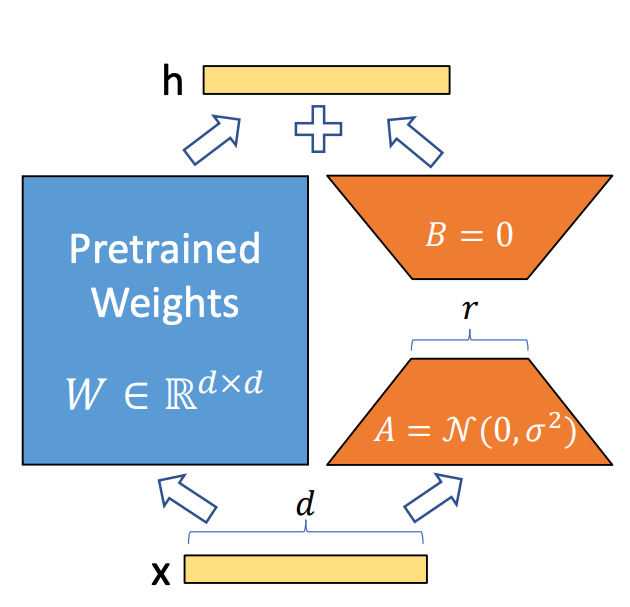

Fine-tuning a model involves updating its weights (also called parameters). LLMs have a lot of weights. The Gemma 2 2B that is being used in this notebook has 2,617,270,528 parameters!

Changing all of them can take quite some time and requires a lot of resources.

To mitigate this issue, you are going to use a technique called: [LoRA: Low-Rank Adaptation](https://arxiv.org/abs/2106.09685)

This technique, in summary, helps lower the number of trained weights needed by a lot, making fine-tuning more accessible.

The key parameter used is the `rank`. In this notebook it set to 4 but you can use higher numbers to get better results but, of course, needed more resources.

**TIP**: Train your model with lower ranks and evaluate the performance improvemnet on your task. Gradually increase the rank in subsequent trials and see if that further boosts performance.

In [ ]:
!pip install peft
from peft import get_peft_model, LoraConfig, TaskType
import torch.nn as nn

lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=lora_rank,   # Using your predefined lora_rank
    lora_alpha=32,
    lora_dropout=0.1
)
gemma_lm = get_peft_model(gemma_lm, lora_config)  # Enable LoRA for the model

print(gemma_lm)  # Hugging Face models don't have a summary method; use print() instead

tokenizer.model_max_length = token_limit  # Set token limit in the tokenizer

from transformers import AdamW

optimizer_grouped_parameters = [
    {'params': [p for n, p in gemma_lm.named_parameters() if not any(nd in n for nd in ["bias", "LayerNorm.weight"])], 'weight_decay': 0.01},
    {'params': [p for n, p in gemma_lm.named_parameters() if any(nd in n for nd in ["bias", "LayerNorm.weight"])], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=lr_value)  # Use AdamW optimizer


loss_fn = nn.CrossEntropyLoss()  # Define the loss function

def forward_pass(input_text):
    inputs = tokenizer(input_text, return_tensors="pt", max_length=token_limit, truncation=True)
    outputs = gemma_lm(**inputs, labels=inputs["input_ids"])
    loss = outputs.loss
    return loss


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 8.4 MB/s eta 0:00:00
PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Gemma2ForCausalLM(
      (model): Gemma2Model(
        (embed_tokens): Embedding(256000, 2304, padding_idx=0)
        (layers): ModuleList(
          (0-25): 26 x Gemma2DecoderLayer(
            (self_attn): Gemma2SdpaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=2304, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2304, out_features=4, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=4, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
     

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Note that enabling LoRA reduces the number of trainable parameters significantly.

From 2,617,270,528 to **2,928,640**

To monitor the learning progress, you will evaluate the model at the end of each epoch and save the lora weights.

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Epoch 1 finished. Running evaluation:

Gemma output:
user
Write a title
model
O Cortiço
TOTAL TIME ELAPSED: 7.93s

Gemma output:
user
Write a poem
model

TOTAL TIME ELAPSED: 4.38s
Epoch 2 finished. Running evaluation:

Gemma output:
user
Write a title
model
A Relíquia
TOTAL TIME ELAPSED: 8.04s

Gemma output:
user
Write a poem
model
O Primo Basílio
TOTAL TIME ELAPSED: 8.19s
Epoch 3 finished. Running evaluation:

Gemma output:
user
Write a title
model
O Primo Basílio
TOTAL TIME ELAPSED: 8.21s

Gemma output:
user
Write a poem
model
O Primo Basílio
TOTAL TIME ELAPSED: 8.18s
Epoch 4 finished. Running evaluation:

Gemma output:
user
Write a title
model
A Sibila
TOTAL TIME ELAPSED: 7.24s

Gemma output:
user
Write a poem
model
O Primo Basílio
TOTAL TIME ELAPSED: 8.21s
Epoch 5 finished. Running evaluation:

Gemma output:
user
Write a title
model
A Sibila
TOTAL TIME ELAPSED: 7.31s

Gemma output:
user
Write a poem
model
O Primo Basílio
TOTAL TIME ELAPSED: 7.77s


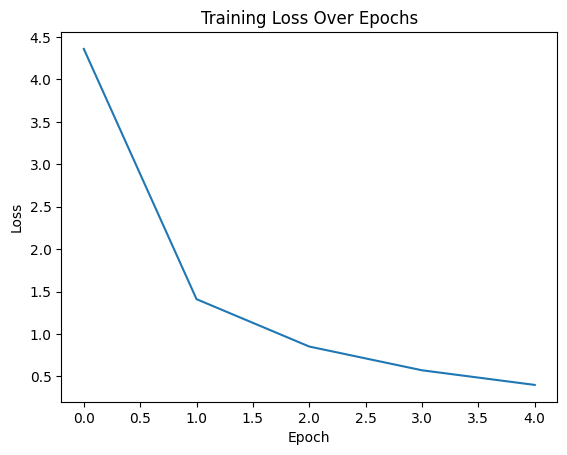

In [ ]:
import torch
import os
import matplotlib.pyplot as plt

# Define a custom callback-like function to handle actions at the end of each epoch
class CustomCallback:
    def __init__(self, model, lora_name, lora_rank, text_gen):
        self.model = model
        self.lora_name = lora_name
        self.lora_rank = lora_rank
        self.text_gen = text_gen  # text_gen function for evaluation

    def on_epoch_end(self, epoch):
        # Save LoRA weights at the end of each epoch
        model_name = f"./{self.lora_name}_{self.lora_rank}_epoch{epoch+1}.lora.pt"
        self.model.save_pretrained(model_name, token=access_token)  # Save model with LoRA weights locally

        # Evaluate the model using text generation
        print(f"Epoch {epoch + 1} finished. Running evaluation:")
        self.text_gen("Write a title")
        self.text_gen("Write a poem")

# Assuming train is your DataLoader and gemma_lm is your model
callback = CustomCallback(gemma_lm, lora_name, lora_rank, text_gen)

# Training loop with callback-like behavior
losses = []
for epoch in range(train_epoch):
    epoch_loss = 0
    for batch in train:  # Assuming `train` is a DataLoader or similar iterable
        optimizer.zero_grad()

        inputs = tokenizer(batch, return_tensors="pt", max_length=token_limit, truncation=True, padding=True)
        labels = inputs["input_ids"]
        outputs = gemma_lm(**inputs, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    losses.append(epoch_loss / len(train))  # Store average loss per epoch

    # Run custom callback at the end of each epoch
    callback.on_epoch_end(epoch)

# Plot training loss over epochs
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.show()

Note that the model began to grasp our intent more effectively from Epoch #3 onwards.

To compare and contrast, it was utlized the "Write a poem" prompt. Interestingly, in Epoch #5, the model began to generate Portuguese in response to that prompt. This shift indicates a strong influence of our training dataset on the model's behavior. However, depending on your application, such a significat change might not be desirable. In such cases, Epoch #4 would be a more suitable choice.

## Load LoRA

Use the code below if you shared LoRA weights. It's much more lightweight than the model files themselves - for instance, a LoRA rank 4 weights file for a 10gb model might only be on the order of a few megabytes, easily shared over email.

In [ ]:
# Example Code for Load LoRA

# from peft import PeftModel

# # Load pre-trained LoRA weights (assuming the weights are saved in Hugging Face format)
# # Load the pre-trained LoRA weights
# lora_weights_path = f"./{lora_name}_{lora_rank}_epoch{train_epoch}.lora.pt"

# # Load the LoRA adapter into the model using PeftModel
# gemma_lm = PeftModel.from_pretrained(gemma_lm, lora_weights_path)

## Try a different sampler

The top-K algorithm randomly picks the next token from the tokens of top K probability.

In [ ]:
import torch

def text_gen_with_top_k(prompt, token_limit=100, top_k=50):  # You can set your token limit and top_k
    tick()

    # Format input, same as your original code
    input_text = f"<start_of_turn>user\n{prompt}<end_of_turn>\n<start_of_turn>model\n"

    # Tokenize input
    inputs = tokenizer(input_text, return_tensors="pt")

    # Generate text using the model with Top-K sampling
    output_tokens = gemma_lm.generate(
        inputs["input_ids"],
        max_length=token_limit,
        do_sample=True,  # Enable sampling
        top_k=top_k,  # Set Top-K sampling strategy
        pad_token_id=tokenizer.eos_token_id  # Prevent errors if the input length exceeds the model's limit
    )

    # Decode the generated tokens back to text
    output = tokenizer.decode(output_tokens[0], skip_special_tokens=True)

    print("\nGemma output:")
    print(output)


# Generate text 5 times using the top_k sampling strategy
text_gen_with_top_k("Write a title", token_limit=100, top_k=50)



Gemma output:
user
Write a title
model
Capitães da Areia


Try a slight different prompts

In [ ]:
text_gen_with_top_k("Write a music title")
text_gen_with_top_k("Write a poem title")
text_gen_with_top_k("Write a blog title")
text_gen_with_top_k("Write a movie title")
text_gen_with_top_k("Write a novel title")


Gemma output:
user
Write a music title
model
A Sibila

Gemma output:
user
Write a poem title
model
O V alienígena

Gemma output:
user
Write a blog title
model
Mar Secreto do Palmar

Gemma output:
user
Write a movie title
model
A Hora da Estrela

Gemma output:
user
Write a novel title
model
Os Maias


## Publish your model

Lets save our model. It takes some time (~11 minutes) as it is a very large file

In [ ]:
# Define the model name (used for both model and tokenizer)
my_model_name = "my_gemma2_lt_pt"

# Save the fine-tuned model to the specified directory
gemma_lm.save_pretrained(f"./{my_model_name}", token=access_token)

# # Save the tokenizer to the same directory
tokenizer.save_pretrained(f"./{my_model_name}")

('./my_gemma2_lt_pt/tokenizer_config.json',
 './my_gemma2_lt_pt/special_tokens_map.json',
 './my_gemma2_lt_pt/tokenizer.model',
 './my_gemma2_lt_pt/added_tokens.json',
 './my_gemma2_lt_pt/tokenizer.json')

## Publishing on Hugging Face

To publish your model on Hugging Face, you'll need your hugging face user (`HF_USER`) and an access token with write permission (`HF_TOKEN`) to the your secret keys.

In [ ]:
# Upload the model to Hugging Face Hub
my_model_name = "my_gemma2_pt"
writeToken = userdata.get("HF_WRITE_TOKEN")
hf_repo_id = f"{my_hf_username}/{my_model_name}"  # Correct format
gemma_lm.push_to_hub(hf_repo_id, token=writeToken)

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/3.21M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/kkech/my_gemma2_pt/commit/bf9ef9f82b6965e7f197d58ee005824158e6ef0b', commit_message='Upload model', commit_description='', oid='bf9ef9f82b6965e7f197d58ee005824158e6ef0b', pr_url=None, pr_revision=None, pr_num=None)